## Optimización combinatoria

Un vendedor debe hacer un recorrido por todas y cada una de las capitales de los 32 estados de los Estados Unidos Mexicanos.

Utilice colonias de hormigas y algoritmos genéticos para encontrar el orden óptimo. El costo de desplazamiento entre ciudades es la suma del valor de la hora del vendedor (es un parámetro que debe estudiarse), el costo de los peajes y el costo del combustible. Cada equipo debe definir en qué carro hace el recorrido el vendedor y de allí extraer el costo del combustible.

Adicionalmente represente con un gif animado o un video cómo se comporta la mejor solución usando un gráfico del recorrido en el mapa de México.

In [7]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Julia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import folium
import numpy as np
from IPython.display import display
import random
from folium import plugins
import seaborn as sns
import matplotlib.pyplot as plt



## Carga y preparación de datos necesarios

El desarrollo del trabajo cuentan con 5 archivos, que servirán para la optimización del recorrido y la actividad. 

coordenadas.csv: Contiene las coordenadas de las capitales de los estados de México.

tiempos.csv: Contiene los tiempos de desplazamiento entre las capitales de los estados de México

distancias.csv: Contiene las distancias entre las capitales de los estados de México.

peajes.csv: Contiene los peajes entre las capitales de los estados de México.

Fuente coordenadas: INEGI - Marco Geoestadístico Nacional 2020
https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469


In [9]:
# Definir rutas de archivos
archivos = {
    'tiempos': './datos/input/tiempos_conduccion.csv',
    'distancias': './datos/input/distancias.csv',
    'coordenadas': './datos/input/coordenadas.csv',
    'peajes': './datos/input/peajes.csv'
}

# Función para cargar y procesar cada archivo
def cargar_archivo(ruta, es_coordenadas=False, **kwargs):
    try:
        if es_coordenadas:
            df = pd.read_csv(ruta, header=None)
            return df.rename(columns={0:'latitude', 1:'longitude'})
        else:
            return pd.read_csv(ruta, index_col=0, **kwargs)
    except Exception as e:
        print(f"Error al cargar {ruta}: {str(e)}")
        return None

# Cargar todos los archivos
datos = {}
for nombre, ruta in archivos.items():
    es_coordenadas = (nombre == 'coordenadas')
    datos[nombre] = cargar_archivo(ruta, es_coordenadas)

# Asignar a variables individuales para mantener compatibilidad
tiempos = datos['tiempos']
distancias = datos['distancias'] 
coordenadas = datos['coordenadas']
peajes = datos['peajes']

# Validar que todos los archivos se cargaron correctamente
archivos_faltantes = [k for k,v in datos.items() if v is None]
if archivos_faltantes:
    raise Exception(f"Error al cargar los siguientes archivos: {archivos_faltantes}")

In [10]:
# Definir los nombres de los estados mexicanos
nombres_estados = [
    'Ciudad de México',
    'Aguascalientes',
    'Baja California',
    'Baja California Sur',
    'Campeche',
    'Chiapas',
    'Chihuahua',
    'Coahuila',
    'Colima',
    'Durango',
    'Guanajuato',
    'Guerrero',
    'Hidalgo',
    'Jalisco',
    'Estado de México',
    'Michoacán',
    'Morelos',
    'Nayarit',
    'Nuevo León',
    'Oaxaca',
    'Puebla',
    'Querétaro',
    'Quintana Roo',
    'San Luis Potosí',
    'Sinaloa',
    'Sonora',
    'Tabasco',
    'Tamaulipas',
    'Tlaxcala',
    'Veracruz',
    'Yucatán',
    'Zacatecas'
]

# Crear un DataFrame que combine las coordenadas con los nombres de las capitales
coordenadas_df = pd.DataFrame({
    'Capital': nombres_estados,
    'Latitud': coordenadas['latitude'],
    'Longitud': coordenadas['longitude']
})

# Mostrar el DataFrame formateado
print("Coordenadas de las Capitales de Estados Mexicanos:")
print("-" * 60)
print(coordenadas_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))

Coordenadas de las Capitales de Estados Mexicanos:
------------------------------------------------------------
            Capital  Latitud  Longitud
   Ciudad de México  21.8805 -102.2967
     Aguascalientes  32.6405 -115.4749
    Baja California  24.1620 -110.3159
Baja California Sur  19.8381  -90.5198
           Campeche  16.7538  -93.1160
            Chiapas  28.5000 -106.0000
          Chihuahua  19.4326  -99.1332
           Coahuila  25.4230 -100.9928
             Colima  19.2431 -103.7281
            Durango  24.0220 -104.6547
         Guanajuato  21.0178 -101.2567
           Guerrero  17.3920  -99.7429
            Hidalgo  20.1045  -98.7889
            Jalisco  20.6720 -103.3384
   Estado de México  19.2925  -99.6569
          Michoacán  19.6546 -101.2624
            Morelos  18.9331  -99.2600
            Nayarit  21.5119 -104.8916
         Nuevo León  25.6802 -100.3153
             Oaxaca  17.0966  -96.7208
             Puebla  19.0437  -98.1981
          Querétaro  20.5955 -

Definimos el tiempo

El propósito es convertir una matriz de tiempos en formato "HH:MM" a una matriz numérica que pueda ser usada para cálculos posteriores en el problema de optimización de rutas.

Por ejemplo:

"1:30" → 1.5000
"2:15" → 2.2500
"0:45" → 0.7500
Esta conversión es necesaria porque los tiempos de viaje son parte del cálculo del costo total de cada ruta posible.

In [11]:
def tiempo_dec(tiempo_str):
    if type(tiempo_str) == str:
        hh,mm = map(int, tiempo_str.split(':'))
        return round(hh+mm/60.0,4) # Convierte los minutos a fracción de hora (minutos/60)
    else:
        return 0
tiempos = tiempos.fillna(0)
tiempos
tiempos_ = tiempos.copy().map(tiempo_dec)
times = tiempos_.to_numpy()

Visualización del mapa de México usando la librería folium, ubicando cada una de sus capitales.

In [12]:
import folium
# Crear mapa centrado en México
m = folium.Map(location=[23.6345, -102.5528], zoom_start=5)

# Agregar marcadores para cada capital
for capital, lat, lon in zip(nombres_estados, coordenadas['latitude'], coordenadas['longitude']):
    folium.Marker(
        location=[lat, lon],
        popup=capital,
        tooltip=capital
    ).add_to(m)

# Mostrar el mapa
m

## Cálculo de salario conductor

Se asume que los conductores ganan un salario basado en horas trabajadas, una vez con los datos de tiempo de desplazamiento fue necesario consultar el salario promedio de los conductores de carga para calcular su salario a través del recorrido que se creará.

Basado en la información público del CONASAMI mexicano, se hallo que el salario de un chofer repartidor de un vehículo con capacidad como el Renault Kangoo es en promedio 46 MXN. 

Esta información se puede visualizar en https://www.gob.mx/cms/uploads/attachment/file/873886/Tabla_de_Salarios_M_nimos_2024.pdf?trk=article-ssr-frontend-pulse_little-text-block.

In [28]:
# Crear matriz de valor por hora multiplicando el salario base por la matriz de tiempos
salario_base = 46  # MXN por hora
val_hora = times * salario_base  # Multiplicar el tiempo de viaje por el salario por hora

# Crear DataFrame
df_valor_hora = pd.DataFrame(val_hora, 
                          index=nombres_estados,
                          columns=nombres_estados)
print(df_valor_hora.round(2))

# Guardar matriz para uso posterior
np.savetxt('./datos/output/valor_hora.csv', val_hora, delimiter=',', fmt='%.2f')

                     Ciudad de México  Aguascalientes  Baja California  \
Ciudad de México                 0.00         1357.77          1346.27   
Aguascalientes                1330.93            0.00          1190.63   
Baja California               1382.30         1180.67             0.00   
Baja California Sur           1163.03         2720.90          2486.30   
Campeche                       821.87         2379.73          2145.13   
Chiapas                        540.50          820.33          1096.33   
Chihuahua                      307.43         1859.93          1625.33   
Coahuila                       329.67         1204.43          1144.63   
Colima                         384.10         1670.57          1435.97   
Durango                        330.43         1140.03           905.43   
Guanajuato                      90.47         1606.93          1372.33   
Guerrero                       649.37         2192.67          1958.07   
Hidalgo                        322.00 

## Peajes
El costo de los peajes de un estado a otro puede encontrarse en la página [tarifascapufe.com.mx.](https://tarifascapufe.com.mx/traza-tu-ruta/) y se recopiló la información con uso de IA para convertirlo en el archivo csv de "peajes.csv"

In [29]:
def procesar_peajes(df_peajes):
    """
    Procesa la matriz de peajes aplicando validaciones y transformaciones necesarias
    
    Args:
        df_peajes (pd.DataFrame): DataFrame con los datos de peajes
    
    Returns:
        np.ndarray: Matriz numpy con los peajes procesados
    """
    # Validar que no haya valores negativos
    if (df_peajes < 0).any().any():
        raise ValueError("Se encontraron peajes con valores negativos")
        
    # Rellenar valores faltantes con 0
    df_peajes = df_peajes.fillna(0)
    
    # Validar simetría de la matriz (costo igual en ambas direcciones)
    if not np.allclose(df_peajes, df_peajes.T):
        print("Advertencia: La matriz de peajes no es simétrica")
        
    # Convertir a array numpy
    peajes_array = df_peajes.to_numpy()
    
    # Validar que la diagonal sea 0 (no hay peaje para viajar al mismo estado)
    np.fill_diagonal(peajes_array, 0)
    
    return peajes_array

# Procesar los peajes
peajes_np = procesar_peajes(peajes)

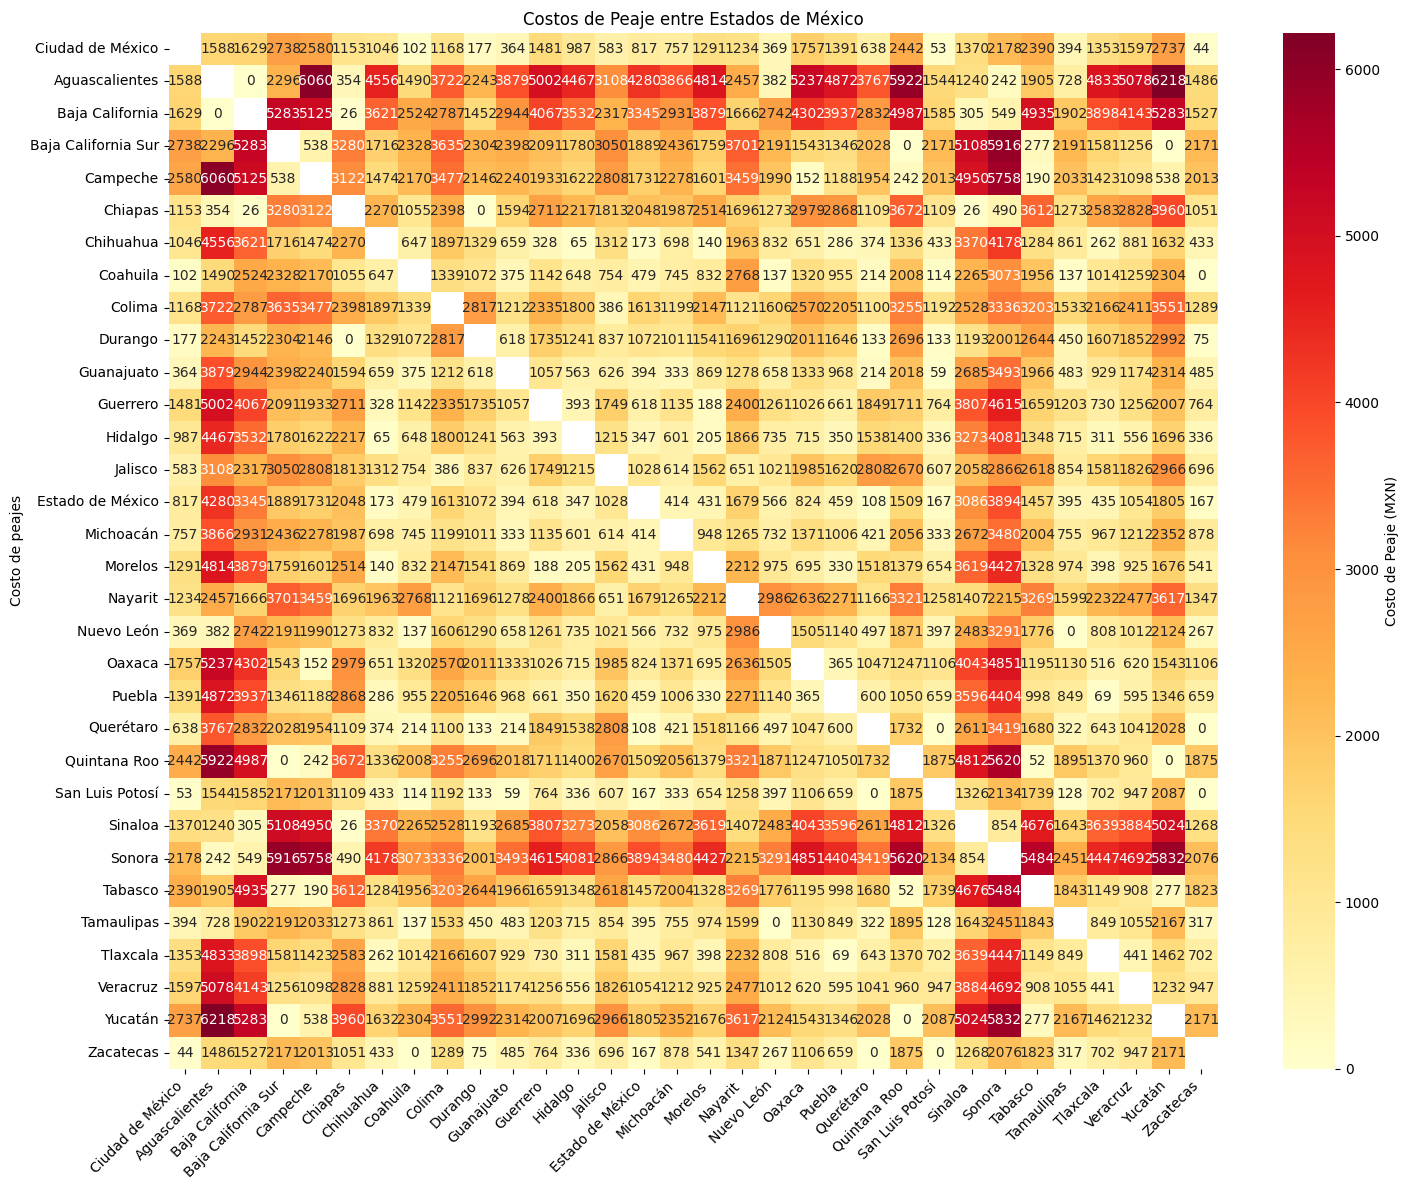


Estadística de Peajes:
Peaje mínimo (excluyendo 0): $26.00 MXN


In [34]:
# Crear un mapa de calor de los peajes
plt.figure(figsize=(15, 12))
sns.heatmap(peajes, 
            xticklabels=nombres_estados,
            yticklabels=nombres_estados,
            cmap='YlOrRd',
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Costo de Peaje (MXN)'})

plt.title('Costos de Peaje entre Estados de México')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Mostrar algunas estadísticas básicas
print("\nEstadística de Peajes:")
print(f"Peaje mínimo (excluyendo 0): ${peajes.values[peajes.values > 0].min():.2f} MXN")

### Costo del combustible

El precio de la gasolina regular en México para 2024 varía dependiendo de la región y otros factores. En promedio, el precio por litro de gasolina regular es de aproximadamente 23.66 pesos. Sin embargo, este precio puede fluctuar ligeramente según la ubicación y las condiciones del mercado. https://www.renault.com.mx/vehiculos-utilitarios/kangoo/datos-tecnicos.html

Elegimos el Renault Kangoo por sus características para carga y distribución para paquetes (Es uno de los carros más usados para transportes de envios nacionales e internacioles)

- Contiene un tanque con capacidad de 50 litros.
- Su rendimiento de cosbustible es de 16 km/1 


Para calcular el costo de combustible se usa la Fórmula de costo de combustible para un viaje por carretera.


costo = (distancia / rendimiento) * precio_gasolina

Donde:

Distancia de un estado a otro se refiere a la distancia total que se recorrerá.
Eficiencia del combustible es el rendimiento del vehículo en términos de kilómetros por litro (km/l) o millas por galón (mpg).
Precio de la gasolina es el costo por unidad de combustible (por litro o por galón).


In [41]:
# Constantes para el cálculo de combustible
RENDIMIENTO_VEHICULO = 16  # km/L
PRECIO_GASOLINA = 23.66    # MXN/L

def calcular_costo_combustible(matriz_distancias):
    """
    Calcula el costo de combustible para cada ruta entre estados.
    
    Args:
        matriz_distancias (pd.DataFrame): Matriz con las distancias entre estados
        
    Returns:
        np.ndarray: Matriz con los costos de combustible
    """
    # Limpia y convierte la matriz de distancias
    distancias = matriz_distancias.fillna(0)
    distancias_np = distancias.to_numpy()
    
    # Calcula el costo de combustible usando la fórmula:
    # costo = (distancia / rendimiento) * precio_gasolina
    costo_combustible = (distancias_np / RENDIMIENTO_VEHICULO) * PRECIO_GASOLINA
    
    # Guarda los resultados
    try:
        np.savetxt(
            './datos/output/costo_combustible.csv', 
            costo_combustible, 
            delimiter=',', 
            fmt='%.2f'
        )
    except IOError as e:
        print(f"Error al guardar archivo: {e}")
        
    return costo_combustible

# Calcula y muestra los costos
costo_combustible = calcular_costo_combustible(distancias)
print("Matriz de costos de combustible calculada y guardada exitosamente")

Matriz de costos de combustible calculada y guardada exitosamente


## Cálculo de costo total
Para calcular el costo total de ir de un estado a otro, se consideran tres componentes principales:

1. Costo del tiempo del conductor: 
   - Salario base del conductor: 46 MXN/hora
   - Multiplicado por el tiempo de viaje entre estados

2. Costo del combustible:
   - Precio de gasolina: 23.66 MXN/L
   - Rendimiento del vehículo (Renault Kangoo): 16 km/L
   - Calculado como: (distancia / rendimiento) * precio_gasolina

3. Costo de peajes:
   - Obtenidos directamente de la matriz de peajes

La fórmula final para el costo entre estados es:

$Costo_{total} = (Salario_{base} * Tiempo_{viaje}) + (\frac{Distancia}{Rendimiento} * Precio_{gasolina}) + Peaje$

Donde:
- $Salario_{base} = 46$ MXN/hora
- $Rendimiento = 16$ km/L
- $Precio_{gasolina} = 23.66$ MXN/L


In [62]:
costo_total = val_hora + peajes + costo_combustible
print(costo_total)

np.savetxt('./datos/output/costo_total.csv', costo_total, delimiter=',', fmt='%.2f')

                            Aguascalientes     Mexicali       La Paz  \
Costo de peajes                                                        
Aguascalientes                         NaN   6126.55945   4955.31445   
Mexicali                        6093.80805          NaN   3192.85930   
La Paz                          4991.34625   3182.89570          NaN   
San Francisco de Campeche       6296.60680  10530.11000  11903.88500   
Tuxtla Gutiérrez                5347.90320  13502.97180  10955.17680   
Chihuahua                       3074.65250   3009.46055   2793.31930   
CDMX                            2069.14680  10237.02180   7690.70555   
Saltillo                        1142.94695   5546.94055   5734.44555   
Colima                          2159.86625   8672.43570   6126.11945   
Victoria de Durango             1104.84680   6080.27180   3676.47680   
Guanajuato                       716.20695   8922.54680   6376.23055   
Chilpancingo de los Bravo       3394.98945  11480.05570   8932.2

# Optimización con algoritmo de colonia de hormigas

In [66]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

# Parámetros del algoritmo de colonia de hormigas
n_states = 32  # Número de estados mexicanos
alpha = 1      # Influencia de las feromonas en la decisión
beta = 2       # Influencia de la visibilidad (costos de viaje)
evaporation_rate = 0.5  # Tasa de evaporación de feromonas
pheromone_constant = 100  # Constante de depósito de feromonas
n_ants = n_states  # Una hormiga por cada estado

# Convertir DataFrame a array numpy si es necesario
if isinstance(costo_total, pd.DataFrame):
    costo_total = costo_total.to_numpy()

# Inicialización de matrices de feromonas y visibilidad
pheromones = np.ones((n_states, n_states))
visibility = np.zeros((n_states, n_states))

# Calcular matriz de visibilidad (inversa del costo)
np.fill_diagonal(visibility, 0)  
for i in range(n_states):
    for j in range(n_states):
        if i != j and costo_total[i,j] != 0:
            visibility[i,j] = 1 / costo_total[i,j]

# Variables para almacenar la mejor solución
mejor_ruta = None
mejor_costo = float('inf')

# Iteraciones principales del algoritmo
for iteracion in range(100):  
    todas_rutas = []
    todos_costos = []

    # Ciclo para cada hormiga
    for hormiga in range(n_ants):
        # Selección aleatoria del estado inicial
        estado_actual = random.randint(0, n_states - 1)
        estados_visitados = [estado_actual]
        costo_ruta = 0  # Cambiado de 'costo' a 'costo_ruta'

        # Construcción de la ruta
        for paso in range(n_states - 1):
            probabilidades = []
            for siguiente_estado in range(n_states):
                if siguiente_estado not in estados_visitados:
                    prob = (pheromones[estado_actual, siguiente_estado] ** alpha) * \
                          (visibility[estado_actual, siguiente_estado] ** beta)
                    probabilidades.append((siguiente_estado, prob))

            if probabilidades:  
                prob_total = sum(prob for _, prob in probabilidades)
                if prob_total > 0:  
                    probabilidades = [(estado, prob/prob_total) for estado, prob in probabilidades]
                    siguiente_estado = random.choices(
                        [estado for estado, _ in probabilidades],
                        weights=[prob for _, prob in probabilidades]
                    )[0]
                else:
                    siguiente_estado = random.choice([estado for estado, _ in probabilidades])
            else:
                break

            # Actualización de costos y estado
            costo_ruta += costo_total[estado_actual, siguiente_estado]
            estado_actual = siguiente_estado
            estados_visitados.append(estado_actual)

        # Completar el ciclo volviendo al inicio
        if len(estados_visitados) == n_states:  
            costo_ruta += costo_total[estado_actual, estados_visitados[0]]
            todas_rutas.append(estados_visitados)
            todos_costos.append(costo_ruta)

            # Actualizar mejor ruta si corresponde
            if costo_ruta < mejor_costo:
                mejor_costo = costo_ruta
                mejor_ruta = estados_visitados.copy()

    # Actualización de feromonas
    pheromones *= (1 - evaporation_rate)  
    for ruta, costo in zip(todas_rutas, todos_costos):
        for i in range(len(ruta) - 1):
            pheromones[ruta[i], ruta[i+1]] += pheromone_constant / costo
        pheromones[ruta[-1], ruta[0]] += pheromone_constant / costo

# Presentación de resultados
if mejor_ruta is None:
    print("No se encontró una solución factible")
else:
    nombres_ruta = [nombres_estados[i] for i in mejor_ruta]
    nombres_ruta.append(nombres_ruta[0])  

    print("\nMejor ruta encontrada (incluyendo retorno al origen):")
    print("→ ".join(nombres_ruta))

    print("\nDesglose de costos por tramo:")
    costo_total_ruta = 0  # Cambiado de 'costo_total' a 'costo_total_ruta'
    print("\n{:<35} {:<35} {:<15}".format("Estado Origen", "Estado Destino", "Costo (MXN)"))
    print("-" * 85)

    for i in range(len(mejor_ruta)):
        estado_actual = mejor_ruta[i]
        siguiente_estado = mejor_ruta[0] if i == len(mejor_ruta) - 1 else mejor_ruta[i + 1]
        costo_tramo = costo_total[estado_actual, siguiente_estado]
        costo_total_ruta += costo_tramo
        print("{:<35} {:<35} ${:<15,.2f}".format(
            nombres_estados[estado_actual],
            nombres_estados[siguiente_estado],
            costo_tramo
        ))

    print(f"\nTotal de estados visitados: {len(nombres_ruta)}")
    print(f"Costo total del recorrido: ${costo_total_ruta:,.2f} MXN")

TypeError: 'int' object is not subscriptable

In [52]:
coordenadas_estados = {estado: (lat, lon) for estado, lat, lon in zip(nombres_estados, coordenadas['latitude'], coordenadas['longitude'])}

In [53]:
import folium
from folium.plugins import AntPath

# Coordenadas aproximadas de cada estado en formato (lat, lon) - ejemplo de coordenadas en México
#crear diccionario apartir de la lista de coordenadas
coordenadas_estados = {estado: (lat, lon) for estado, lat, lon in zip(nombres_estados, coordenadas['latitude'], coordenadas['longitude'])}


# Ruta del recorrido en orden
ruta = best_route_names  # Reemplaza con tu ruta optimizada

# Inicializar el mapa centrado en México
m = folium.Map(location=[23.6345, -102.5528], zoom_start=5)

inicio_coord = coordenadas_estados[ruta[0]]
folium.Marker(
    location=inicio_coord,
    popup="Inicio",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)

# Añadir un marcador especial para el fin (último estado en la ruta)
fin_coord = coordenadas_estados[ruta[-1]]
folium.Marker(
    location=fin_coord,
    popup="Fin",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)


for estado in ruta[1:-1]:  # Excluir inicio y fin para evitar superposición
    coord = coordenadas_estados[estado]
    folium.Marker(location=coord, popup=f"Estado {estado}").add_to(m)

# Construir la ruta animada con AntPath
ruta_coords = [coordenadas_estados[estado] for estado in ruta]
AntPath(ruta_coords, color="blue", weight=4, opacity=0.8).add_to(m)
m

## Optimización usando algoritmos genéticos

In [ ]:
import numpy as np
import random

random.seed(42)
np.random.seed(42)

# Parámetros del problema
n_states = 32  # Número de estados
n_population = 100  # Tamaño de la población
n_generations = 200  # Número de generaciones
mutation_rate = 0.01  # Tasa de mutación

# Genera una ruta aleatoria
def generate_route():
    route = list(range(n_states))
    random.shuffle(route)
    return route

# Calcula el costo total de una ruta
def calculate_cost(route):
    total_cost = 0
    segments = []

    # Calcula el costo entre cada par de estados consecutivos
    for i in range(n_states - 1):
        cost = matriz_de_costos_final[route[i], route[i + 1]]
        total_cost += cost
        segments.append((route[i], route[i + 1], cost))

    # Añade el costo del retorno al estado inicial
    cost_return = matriz_de_costos_final[route[-1], route[0]]
    total_cost += cost_return
    segments.append((route[-1], route[0], cost_return))

    return total_cost, segments

# Genera la población inicial
population = [generate_route() for _ in range(n_population)]

# Seguimiento de la mejor ruta en cada generación
best_costs_per_generation = []

# Algoritmo evolutivo
for generation in range(n_generations):
    # Evaluación de la aptitud
    fitness_scores = [(route, *calculate_cost(route)) for route in population]
    fitness_scores.sort(key=lambda x: x[1])  # Ordena por costo

    # Guarda el mejor costo de esta generación
    best_costs_per_generation.append(fitness_scores[0][1])

    # Selección (elitismo: conserva las mejores rutas)
    elite_size = int(0.1 * n_population)  # Mantener el 10% de la mejor población
    new_population = [route for route, _, _ in fitness_scores[:elite_size]]

    # Generación de nuevos individuos (crossover y mutación)
    while len(new_population) < n_population:
        # Selección de padres
        parent1, parent2 = random.choices(population, k=2)

        # Crossover (Orden basado en cruce)
        crossover_point = random.randint(1, n_states - 2)
        child = parent1[:crossover_point] + [state for state in parent2 if state not in parent1[:crossover_point]]

        # Mutación
        if random.random() < mutation_rate:
            i, j = random.sample(range(n_states), 2)
            child[i], child[j] = child[j], child[i]  # Intercambia dos estados aleatorios

        new_population.append(child)

    population = new_population  # Actualiza la población para la siguiente generación

# Mejor ruta encontrada
best_route, best_cost, best_segments = min(fitness_scores, key=lambda x: x[1])
best_route_names = [nombres_estados[i] for i in best_route]
# Agregar explícitamente el retorno al estado inicial
best_route_names.append(best_route_names[0])

# Mostrar resultados
print("\nMejor ruta encontrada (incluyendo retorno al inicio):")
print("→ ".join(best_route_names))

print("\nDesglose del costo por segmento:")
print("\n{:<35} {:<35} {:<15}".format("Origen", "Destino", "Costo (MXN)"))
print("-" * 85)

for origin, destination, cost in best_segments:
    print("{:<35} {:<35} ${:<15,.2f}".format(
        nombres_estados[origin],
        nombres_estados[destination],
        cost
    ))

print("\nEstadísticas del viaje:")
print(f"Número total de estados visitados: {len(best_route_names)} (incluyendo el retorno al inicio)")
print(f"Costo total del viaje: ${best_cost:,.2f} MXN")
print(f"Costo promedio por segmento: ${best_cost/len(best_route):,.2f} MXN")

# Estadísticas de la evolución
print("\nEstadísticas de la evolución:")
print(f"Costo inicial (mejor de la primera generación): ${best_costs_per_generation[0]:,.2f} MXN")
print(f"Costo final (mejor de la última generación): ${best_costs_per_generation[-1]:,.2f} MXN")
print(f"Mejora total: ${(best_costs_per_generation[0] - best_costs_per_generation[-1]):,.2f} MXN")
print(f"Porcentaje de mejora: {((best_costs_per_generation[0] - best_costs_per_generation[-1]) / best_costs_per_generation[0] * 100):,.2f}%")


Mejor ruta encontrada (incluyendo retorno al inicio):
Zacatecas→ Cuernavaca→ Saltillo→ Monterrey→ Ciudad Victoria→ San Luis Potosí→ Aguascalientes→ Guadalajara→ Culiacán Rosales→ Hermosillo→ Tepic→ Colima→ Guanajuato→ Pachuca de Soto→ Morelia→ Santiago de Querétaro→ Tlaxcala de Xicohténcatl→ CDMX→ Chilpancingo de los Bravo→ Chetumal→ Mérida→ San Francisco de Campeche→ Tuxtla Gutiérrez→ Villahermosa→ Xalapa-Enríquez→ Oaxaca de Juárez→ Heroica Puebla de Zaragoza→ Toluca de Lerdo→ Victoria de Durango→ Chihuahua→ Mexicali→ La Paz→ Zacatecas

Desglose del costo por segmento:

Origen                              Destino                             Costo (MXN)    
-------------------------------------------------------------------------------------
Zacatecas                           Cuernavaca                          $1,962.49       
Cuernavaca                          Saltillo                            $2,731.64       
Saltillo                            Monterrey                        

In [ ]:
coordenadas_estados = {estado: (lat, lon) for estado, lat, lon in zip(nombres_estados, coordenadas['latitude'], coordenadas['longitude'])}

In [ ]:
import folium
from folium.plugins import AntPath

# Coordenadas aproximadas de cada estado en formato (lat, lon) - ejemplo de coordenadas en México
#crear diccionario apartir de la lista de coordenadas
coordenadas_estados = {estado: (lat, lon) for estado, lat, lon in zip(nombres_estados, coordenadas['latitude'], coordenadas['longitude'])}
# Ruta del recorrido en orden
ruta = best_route_names  # Reemplaza con tu ruta optimizada

# Inicializar el mapa centrado en México
m = folium.Map(location=[23.6345, -102.5528], zoom_start=5)

inicio_coord = coordenadas_estados[ruta[0]]
folium.Marker(
    location=inicio_coord,
    popup="Inicio",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)

# Añadir un marcador especial para el fin (último estado en la ruta)
fin_coord = coordenadas_estados[ruta[-1]]
folium.Marker(
    location=fin_coord,
    popup="Fin",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)


for estado in ruta[1:-1]:  # Excluir inicio y fin para evitar superposición
    coord = coordenadas_estados[estado]
    folium.Marker(location=coord, popup=f"Estado {estado}").add_to(m)

# Construir la ruta animada con AntPath
ruta_coords = [coordenadas_estados[estado] for estado in ruta]
AntPath(ruta_coords, color="blue", weight=4, opacity=0.8).add_to(m)
m

Haciendo una comparación entre ambos algoritmos, vemos que el de colonia de hormigas optimiza de una mejor manera los costos de transporte en la mejor ruta que los algoritmos genéticos, esto lo podemos ver en el costo final de cada ruta en cada algoritmo, para colonia de hormigas obtuvimos un costo de \$36590.41 MXN, mientras que para los algoritmos genéticos se obtiene un costo total de \$57689.98 MXN

# Usando el mismo punto de partida

## Algoritmos genéticos

In [ ]:
import numpy as np
import random

random.seed(42)
np.random.seed(42)

# Parámetros del problema
n_states = 32  # Número de estados
n_population = 100  # Tamaño de la población
n_generations = 200  # Número de generaciones
mutation_rate = 0.01  # Tasa de mutación

# Genera una ruta aleatoria comenzando desde Ciudad de México (índice 0)
def generate_route():
    route = list(range(1, n_states))  # Empieza con los demás estados (excepto Ciudad de México)
    random.shuffle(route)
    route = [0] + route  # Inserta Ciudad de México (índice 0) al inicio
    return route

# Calcula el costo total de una ruta
def calculate_cost(route):
    total_cost = 0
    segments = []

    # Calcula el costo entre cada par de estados consecutivos
    for i in range(n_states - 1):
        cost = matriz_de_costos_final[route[i], route[i + 1]]
        total_cost += cost
        segments.append((route[i], route[i + 1], cost))

    # Añade el costo del retorno al estado inicial
    cost_return = matriz_de_costos_final[route[-1], route[0]]
    total_cost += cost_return
    segments.append((route[-1], route[0], cost_return))

    return total_cost, segments

# Genera la población inicial
population = [generate_route() for _ in range(n_population)]

# Seguimiento de la mejor ruta en cada generación
best_costs_per_generation = []

# Algoritmo evolutivo
for generation in range(n_generations):
    # Evaluación de la aptitud
    fitness_scores = [(route, *calculate_cost(route)) for route in population]
    fitness_scores.sort(key=lambda x: x[1])  # Ordena por costo

    # Guarda el mejor costo de esta generación
    best_costs_per_generation.append(fitness_scores[0][1])

    # Selección (elitismo: conserva las mejores rutas)
    elite_size = int(0.1 * n_population)  # Mantener el 10% de la mejor población
    new_population = [route for route, _, _ in fitness_scores[:elite_size]]

    # Generación de nuevos individuos (crossover y mutación)
    while len(new_population) < n_population:
        # Selección de padres
        parent1, parent2 = random.choices(population, k=2)

        # Crossover (Orden basado en cruce)
        crossover_point = random.randint(1, n_states - 2)
        child = parent1[:crossover_point] + [state for state in parent2 if state not in parent1[:crossover_point]]

        # Mutación
        if random.random() < mutation_rate:
            i, j = random.sample(range(n_states), 2)
            child[i], child[j] = child[j], child[i]  # Intercambia dos estados aleatorios

        new_population.append(child)

    population = new_population  # Actualiza la población para la siguiente generación

# Mejor ruta encontrada
best_route, best_cost, best_segments = min(fitness_scores, key=lambda x: x[1])
best_route_names = [nombres_estados[i] for i in best_route]
# Agregar explícitamente el retorno al estado inicial
best_route_names.append(best_route_names[0])

# Mostrar resultados
print("\nMejor ruta encontrada (incluyendo retorno al inicio):")
print("→ ".join(best_route_names))

print("\nDesglose del costo por segmento: ")
print("\n{:<35} {:<35} {:<15}".format("Origen", "Destino", "Costo (MXN)"))
print("-" * 85)

for origin, destination, cost in best_segments:
    print("{:<35} {:<35} ${:<15,.2f}".format(
        nombres_estados[origin],
        nombres_estados[destination],
        cost
    ))

print("\nEstadísticas del viaje:")
print(f"Número total de estados visitados: {len(best_route_names)} (incluyendo el retorno al inicio)")
print(f"Costo total del viaje: ${best_cost:,.2f} MXN")
print(f"Costo promedio por segmento: ${best_cost/len(best_route):,.2f} MXN")

# Estadísticas de la evolución
print("\nEstadísticas de la evolución:")
print(f"Costo inicial (mejor de la primera generación): ${best_costs_per_generation[0]:,.2f} MXN")
print(f"Costo final (mejor de la última generación): ${best_costs_per_generation[-1]:,.2f} MXN")
print(f"Mejora total: ${(best_costs_per_generation[0] - best_costs_per_generation[-1]):,.2f} MXN")
print(f"Porcentaje de mejora: {((best_costs_per_generation[0] - best_costs_per_generation[-1]) / best_costs_per_generation[0] * 100):,.2f}%")



Mejor ruta encontrada (incluyendo retorno al inicio):
Aguascalientes→ Santiago de Querétaro→ CDMX→ Toluca de Lerdo→ Guadalajara→ Colima→ Morelia→ Chilpancingo de los Bravo→ Heroica Puebla de Zaragoza→ Oaxaca de Juárez→ Tuxtla Gutiérrez→ Villahermosa→ Tlaxcala de Xicohténcatl→ Guanajuato→ Victoria de Durango→ Culiacán Rosales→ La Paz→ Chihuahua→ Saltillo→ San Luis Potosí→ San Francisco de Campeche→ Mérida→ Chetumal→ Xalapa-Enríquez→ Pachuca de Soto→ Cuernavaca→ Tepic→ Hermosillo→ Mexicali→ Monterrey→ Ciudad Victoria→ Zacatecas→ Aguascalientes

Desglose del costo por segmento: 

Origen                              Destino                             Costo (MXN)    
-------------------------------------------------------------------------------------
Aguascalientes                      Santiago de Querétaro               $1,244.42       
Santiago de Querétaro               CDMX                                $798.88         
CDMX                                Toluca de Lerdo            

In [ ]:
import folium
from folium.plugins import AntPath

# Coordenadas aproximadas de cada estado en formato (lat, lon) - ejemplo de coordenadas en México
#crear diccionario apartir de la lista de coordenadas
coordenadas_estados = {estado: (lat, lon) for estado, lat, lon in zip(nombres_estados, coordenadas['latitude'], coordenadas['longitude'])}


# Ruta del recorrido en orden
ruta = best_route_names  # Reemplaza con tu ruta optimizada

# Inicializar el mapa centrado en México
m = folium.Map(location=[23.6345, -102.5528], zoom_start=5)

inicio_coord = coordenadas_estados[ruta[0]]
folium.Marker(
    location=inicio_coord,
    popup="Inicio",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)

# Añadir un marcador especial para el fin (último estado en la ruta)
fin_coord = coordenadas_estados[ruta[-1]]
folium.Marker(
    location=fin_coord,
    popup="Fin",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)


for estado in ruta[1:-1]:  # Excluir inicio y fin para evitar superposición
    coord = coordenadas_estados[estado]
    folium.Marker(location=coord, popup=f"Estado {estado}").add_to(m)

# Construir la ruta animada con AntPath
ruta_coords = [coordenadas_estados[estado] for estado in ruta]
AntPath(ruta_coords, color="blue", weight=4, opacity=0.8).add_to(m)
m.save("/content/output/rutas_algoritmo_genetico_animado_partida_fija.html")
display(m)

## Colonia de hormigas

In [ ]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

# Parámetros del algoritmo
n_states = 32  # Número de estados
alpha = 1      # Influencia de las feromonas
beta = 2       # Influencia de la visibilidad (tiempos de viaje)
evaporation_rate = 0.5
pheromone_constant = 100
n_ants = n_states  # Usar una hormiga por estado

# Inicializa la matriz de feromonas
pheromones = np.ones((n_states, n_states))  # Cantidad inicial de feromonas

# Cálculo de visibilidad (inversa del tiempo de viaje, para que tiempos menores sean más atractivos)
visibility = 1 / matriz_de_costos_final
visibility[visibility == np.inf] = 0  # Evitar divisiones por cero

# Ejecución del algoritmo
best_route = None
best_cost = float('inf')

for iteration in range(100):  # Número de iteraciones para el algoritmo
    all_routes = []
    all_costs = []

    # Para cada hormiga
    for ant in range(n_ants):
        # Fijar el estado inicial a Ciudad de México (índice 0)
        current_state = 0  # Ciudad de México
        visited_states = [current_state]
        cost = 0

        # Construcción de la ruta completa
        for step in range(n_states - 1):
            # Calcular probabilidades para el próximo estado
            probabilities = []
            for next_state in range(n_states):
                if next_state not in visited_states:
                    prob = (pheromones[current_state][next_state] ** alpha) * (visibility[current_state][next_state] ** beta)
                    probabilities.append((next_state, prob))

            # Seleccionar el próximo estado basado en las probabilidades
            next_state = random.choices(
                [state for state, _ in probabilities],
                weights=[prob for _, prob in probabilities]
            )[0]

            # Actualizar el costo y el estado actual
            cost += matriz_de_costos_final[current_state][next_state]
            current_state = next_state
            visited_states.append(current_state)

        # Completa el ciclo regresando al punto inicial
        cost += matriz_de_costos_final[current_state][visited_states[0]]
        all_routes.append(visited_states)
        all_costs.append(cost)

        # Actualización de la mejor ruta
        if cost < best_cost:
            best_cost = cost
            best_route = visited_states

    # Actualización de feromonas
    pheromones *= (1 - evaporation_rate)  # Evaporación de feromonas
    for route, cost in zip(all_routes, all_costs):
        for i in range(n_states - 1):
            pheromones[route[i]][route[i + 1]] += pheromone_constant / cost
        # Retorno al punto inicial
        pheromones[route[-1]][route[0]] += pheromone_constant / cost

# Convertir la ruta a nombres de estados y mostrar el ciclo completo
best_route_names = [nombres_estados[i] for i in best_route]
# Agregar explícitamente el retorno al estado inicial
best_route_names.append(best_route_names[0])

print("\nMejor ruta encontrada (incluyendo retorno al inicio):")
print("→ ".join(best_route_names))

print("\nDesglose del costo por segmento:")
total_cost = 0
print("\n{:<35} {:<35} {:<15}".format("Origen", "Destino", "Costo (MXN)"))
print("-" * 85)

for i in range(len(best_route)):
    # Costo entre estados consecutivos
    current_state = best_route[i]
    next_state = best_route[0] if i == len(best_route) - 1 else best_route[i + 1]
    cost_segment = matriz_de_costos_final[current_state][next_state]
    total_cost += cost_segment
    print("{:<35} {:<35} ${:<15,.2f}".format(
        nombres_estados[current_state],
        nombres_estados[next_state],
        cost_segment
    ))

print("\nEstadísticas del viaje:")
print(f"Número total de estados visitados: {len(best_route_names)} (incluyendo el retorno al inicio)")
print(f"Costo total del viaje: ${total_cost:,.2f} MXN")
print(f"Costo promedio por segmento: ${total_cost/len(best_route):,.2f} MXN")



<ipython-input-38-59e10dc8246c>:19: RuntimeWarning: divide by zero encountered in divide
  visibility = 1 / matriz_de_costos_final



Mejor ruta encontrada (incluyendo retorno al inicio):
Aguascalientes→ Zacatecas→ San Luis Potosí→ Ciudad Victoria→ Monterrey→ Saltillo→ Guanajuato→ Santiago de Querétaro→ Toluca de Lerdo→ CDMX→ Cuernavaca→ Chilpancingo de los Bravo→ Pachuca de Soto→ Tlaxcala de Xicohténcatl→ Heroica Puebla de Zaragoza→ Oaxaca de Juárez→ Tuxtla Gutiérrez→ Villahermosa→ San Francisco de Campeche→ Mérida→ Chetumal→ Xalapa-Enríquez→ Morelia→ Guadalajara→ Colima→ Tepic→ Culiacán Rosales→ La Paz→ Hermosillo→ Mexicali→ Chihuahua→ Victoria de Durango→ Aguascalientes

Desglose del costo por segmento:

Origen                              Destino                             Costo (MXN)    
-------------------------------------------------------------------------------------
Aguascalientes                      Zacatecas                           $292.88         
Zacatecas                           San Luis Potosí                     $613.62         
San Luis Potosí                     Ciudad Victoria             

In [ ]:
import folium
from folium.plugins import AntPath

# Coordenadas aproximadas de cada estado en formato (lat, lon) - ejemplo de coordenadas en México
#crear diccionario apartir de la lista de coordenadas
coordenadas_estados = {estado: (lat, lon) for estado, lat, lon in zip(nombres_estados, coordenadas['latitude'], coordenadas['longitude'])}


# Ruta del recorrido en orden
ruta = best_route_names  # Reemplaza con tu ruta optimizada

# Inicializar el mapa centrado en México
m = folium.Map(location=[23.6345, -102.5528], zoom_start=5)

inicio_coord = coordenadas_estados[ruta[0]]
folium.Marker(
    location=inicio_coord,
    popup="Inicio",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)

# Añadir un marcador especial para el fin (último estado en la ruta)
fin_coord = coordenadas_estados[ruta[-1]]
folium.Marker(
    location=fin_coord,
    popup="Fin",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)


for estado in ruta[1:-1]:  # Excluir inicio y fin para evitar superposición
    coord = coordenadas_estados[estado]
    folium.Marker(location=coord, popup=f"Estado {estado}").add_to(m)

# Construir la ruta animada con AntPath
ruta_coords = [coordenadas_estados[estado] for estado in ruta]
AntPath(ruta_coords, color="blue", weight=4, opacity=0.8).add_to(m)
m.save('/content/output/rutas_colonia_hormigas_animado_partida_fija.html')
display(m)